<a href="https://colab.research.google.com/github/WeilongYE/unet-for-cityscapes-road-segmentation/blob/main/unet_for_cityscapes_road_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet for Cityscapes Road Segmentation

## Table of Contents
- 1. Data Preparation
  - 1.1 Download Datasets
    - 1.1.1 Setup Kaggle API Key in Colab
    - 1.1.2 Download Dataset
  - 1.2 Data Inspection
    - 1.2.1 Check Relative RGB and Label Images
    - 1.2.2 General Info
    - 1.2.3 Label Info
  - 1.3 Load and Preprocess Datasets
    - 1.3.1 Binary Datasets

## 1. Data Preparation

### 1.1 Download Datasets
All the datasets are downloaded from Kaggle.

#### 1.1.1 Setup Kaggle API Key in Colab

In [1]:
# Step 1: Get the Kaggle API Key. https://www.kaggle.com/docs/api#authentication
# - Go to Kaggle and log in.
# - Click on your profile picture (top right), then select Settings.
# - Scroll down to the API section and click Create New API Token.
# - A file named kaggle.json will be downloaded.
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Step 2: Move kaggle key to proper location
import os
import shutil
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

Saving kaggle.json to kaggle.json


#### 1.1.2 Download Dataset
Kaggle datasets link: https://www.kaggle.com/datasets/weilongye/cityscapes-leftimg-and-fineannotations-preprocessed
Dataset preparation script: https://github.com/WeilongYE/unet-for-cityscapes-road-segmentation/blob/main/cityscapes_datasets_preparation.ipynb

In [ ]:
# Downlad datasets from Kaggle
import kagglehub
import os, shutil
path = kagglehub.dataset_download("weilongye/cityscapes-leftimg-and-fineannotations-preprocessed")
print("Path to dataset files:", path)
dataset_dir = "cityscapes_data"
shutil.rmtree(dataset_dir, ignore_errors=True)
os.makedirs(dataset_dir, exist_ok=True)
# move all subfolders in path to dataset_dir
for root, dirs, files in os.walk(path):
  for dir in dirs:
    shutil.move(os.path.join(root, dir), dataset_dir)

100%|██████████| 386M/386M [00:03<00:00, 121MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/weilongye/cityscapes-leftimg-and-fineannotations-preprocessed/versions/1


### 1.2 Inspect Data
#### 1.2.1 Check Relative RGB and Label Images

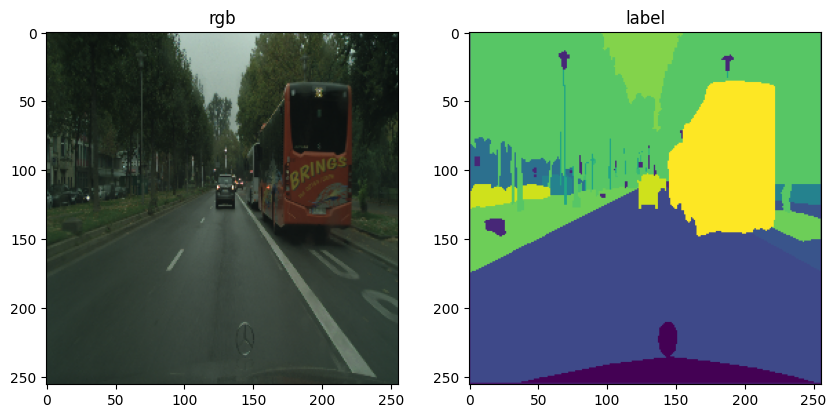

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

train_rgb_dir = os.path.join(dataset_dir, "train/rgb")
val_rgb_dir = os.path.join(dataset_dir, "val/rgb")
train_rgb_files = os.listdir(train_rgb_dir)
val_rgb_files = os.listdir(val_rgb_dir)

train_label_dir = os.path.join(dataset_dir, "train/label")
val_label_dir = os.path.join(dataset_dir, "val/label")
train_label_files = os.listdir(train_label_dir)
val_label_files = os.listdir(val_label_dir)

# Check if all filenames in train/rgb are also in train/label
for file in train_rgb_files:
  if file not in train_label_files:
    print(file)
    raise Exception(f"Sorry, there is no relative label file for {file}")

# Check if all filenames in val/rgb are also in val/label
for file in val_rgb_files:
  if file not in val_label_files:
    print(file)
    raise Exception(f"Sorry, there is no relative label file for {file}")

common_filename = train_rgb_files[0]
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].set_title("rgb")
axis[0].imshow(Image.open(os.path.join(train_rgb_dir, common_filename)))
axis[1].set_title("label")
axis[1].imshow(Image.open(os.path.join(train_label_dir, common_filename)))
plt.show()

#### 1.2.2 General Info

In [4]:
print(f"Number of train samples: {len(train_rgb_files)}")
print(f"Number of val samples: {len(val_rgb_files)}")
print(f"Shape of RGB images: {np.array(Image.open(os.path.join(train_rgb_dir,train_rgb_files[0]))).shape}")
print(f"Shape of label images: {np.array(Image.open(os.path.join(train_label_dir,train_label_files[0]))).shape}")


Number of train samples: 2975
Number of val samples: 500
Shape of RGB images: (256, 256, 3)
Shape of label images: (256, 256)


#### 1.2.3 Label Info
Below code cell is a partial copy of https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py


In [5]:
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [6]:
name_to_id = {label.name: label.id for label in labels}
road_id = name_to_id["road"]
print(f"The id of road is: {road_id}")

The id of road is: 7


(256, 256, 1)
[ 1  3  4  7  8 11 13 17 19 20 21 22 23 26 28]


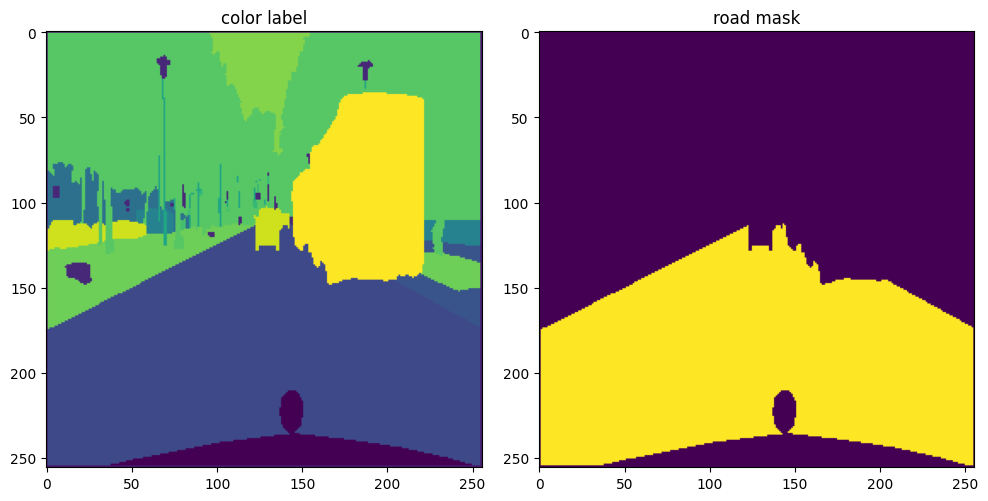

In [7]:
# Inspect one label image
one_label_img = np.array(Image.open(os.path.join(train_label_dir, train_label_files[0])))
# reshape label image to three dimention
one_label_img = np.reshape(one_label_img, (one_label_img.shape[0], one_label_img.shape[1], 1))
print(one_label_img.shape)
print(np.unique(one_label_img))

road_mask = np.all(one_label_img == road_id, axis=-1).astype(np.uint8)
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(one_label_img)
axis[0].set_title("color label")
axis[1].imshow(road_mask)
axis[1].set_title("road mask")
plt.tight_layout()
plt.show()

### 1.3 Load and Preprocess Datasets
In this experiment, three strategies will be used:
- Binary semantic segmentation: road class vs non-road class
- Multi-class semantic segmentation based on *id*

Constraints:
- Three dataset should have same resolution

In [8]:
import keras
class DataLoader:
  @staticmethod
  def preprocess_rgb(image: Image, input_shape) -> np.ndarray:
    # resize to input shape
    image = image.resize(input_shape[:2], Image.NEAREST)
    # normalize
    image = np.array(image) / 255.0
    return image

  @staticmethod
  def preprocess_label(label: Image, input_shape, road_id, num_of_classes, one_hot=False) -> np.ndarray:
    # resize to input shape
    label = label.resize(input_shape[:2], Image.NEAREST)
    # convert multi-class label to road binary mask
    label = np.array(label)
    label = np.reshape(label, (label.shape[0], label.shape[1], 1))
    label = np.all(label == road_id, axis=-1).astype(np.uint8)

    if one_hot:  # For using categorical cross entropy instead of sparse categorical cross entropy
      label = keras.utils.to_categorical(label, num_of_classes)

    return label

  def __init__(self, train_rgb_dir, train_label_dir, val_rgb_dir, val_label_dir, input_shape, road_id, num_of_classes):
    self.train_rgb_dir = train_rgb_dir
    self.train_label_dir = train_label_dir
    self.val_rgb_dir = val_rgb_dir
    self.val_label_dir = val_label_dir
    self.input_shape = input_shape
    self.road_id = road_id
    self.num_of_classes = num_of_classes

  def generate_binary_datasets(self):
    train_rgb_files = os.listdir(self.train_rgb_dir)
    train_label_files = os.listdir(self.train_label_dir)
    val_rgb_files = os.listdir(self.val_rgb_dir)
    val_label_files = os.listdir(self.val_label_dir)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for file in train_rgb_files:
      # Load and preprocess image
      image_train = Image.open(os.path.join(self.train_rgb_dir, file))
      image_train = DataLoader.preprocess_rgb(image_train, self.input_shape)
      # Load and preprocess label
      label_train = Image.open(os.path.join(self.train_label_dir, file))
      label_train = DataLoader.preprocess_label(label_train, self.input_shape, self.road_id, self.num_of_classes)
      # Add to dataset
      X_train.append(image_train)
      Y_train.append(label_train)

    for file in val_rgb_files:
      # Load and preprocess image
      image_train = Image.open(os.path.join(self.val_rgb_dir, file))
      image_train = DataLoader.preprocess_rgb(image_train, self.input_shape)
      # Load and preprocess label
      label_train = Image.open(os.path.join(self.val_label_dir, file))
      label_train = DataLoader.preprocess_label(label_train, self.input_shape, self.road_id, self.num_of_classes)
      # Add to dataset
      X_val.append(image_train)
      Y_val.append(label_train)

    return np.array(X_train), np.array(Y_train), np.array(X_val), np.array(Y_val)

(128, 128, 3)
(128, 128)
[0 1]


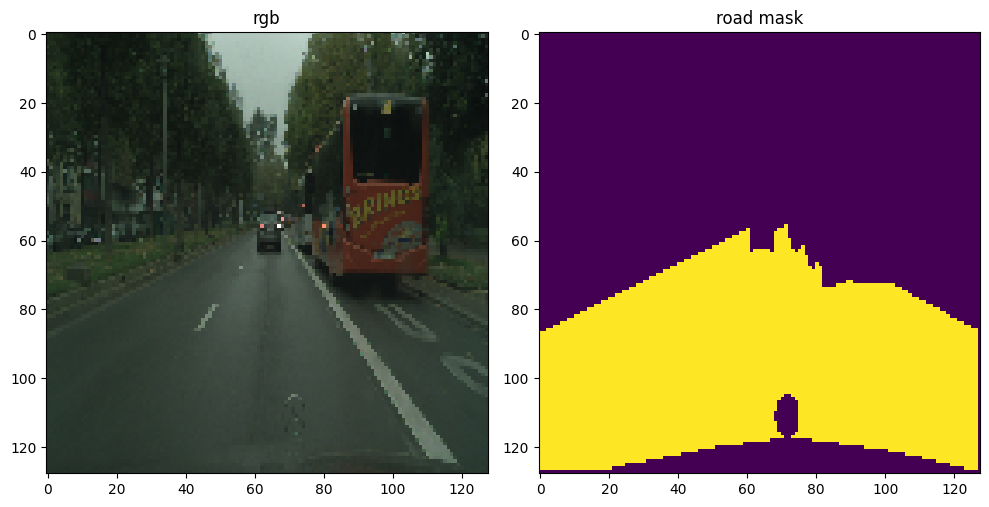

In [9]:
# Test preprocess_rgb
input_shape = (128, 128, 3)
test_image = Image.open(os.path.join(train_rgb_dir, train_rgb_files[0]))
test_image = DataLoader.preprocess_rgb(test_image, input_shape)
print(test_image.shape)

# Test preprocess_label
test_label = Image.open(os.path.join(train_label_dir, train_label_files[0]))
test_label = DataLoader.preprocess_label(test_label, input_shape, road_id, 2, False)
print(test_label.shape)
print(np.unique(test_label))

fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(test_image)
axis[0].set_title("rgb")
axis[1].imshow(test_label)
axis[1].set_title("road mask")
plt.tight_layout()
plt.show()

In [10]:
num_of_classes = 2
binary_data_loader = DataLoader(train_rgb_dir, train_label_dir, val_rgb_dir, val_label_dir, input_shape, road_id, num_of_classes)
X_train, Y_train, X_val, Y_val = binary_data_loader.generate_binary_datasets()

In [11]:
# Check loaded binary datasets
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(2975, 128, 128, 3)
(2975, 128, 128)
(500, 128, 128, 3)
(500, 128, 128)


## 2 Build UNet Model

### 2.1 UNet Architecture
TODO: add details of applied UNet architecture


### 2.2 Implementation

In [22]:
from logging import logProcesses
import tensorflow as tf
import tensorflow.keras.layers as tfl
from datetime import datetime
import json

class UNet:
  def __init__(self, input_shape, num_of_filters, num_of_classes):
    self.input_shape = input_shape
    self.num_of_filters = num_of_filters
    self.num_of_classes = num_of_classes
    self.model = None

  def build(self):
    def double_conv(x, num_of_filters, dropout_prob):
      x = tfl.Conv2D(num_of_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
      x = tfl.Conv2D(num_of_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
      if dropout_prob > 0:
        x = tfl.Dropout(dropout_prob)(x)
      return x

    def down(x):
      return tfl.MaxPooling2D(pool_size=(2,2))(x)

    def up(expansive_input, contractive_input, num_of_filters):
      x = tfl.Conv2DTranspose(num_of_filters, 3, strides=(2,2), padding="same")(expansive_input)
      return tfl.concatenate([x, contractive_input], axis=3)

    # Encoder
    inputs = tfl.Input(input_shape)
    encoder_conv_1 = double_conv(inputs, self.num_of_filters, 0)
    encoder_down_1 = down(encoder_conv_1)
    encoder_conv_2 = double_conv(encoder_down_1, self.num_of_filters * 2, 0)
    encoder_down_2 = down(encoder_conv_2)
    encoder_conv_3 = double_conv(encoder_down_2, self.num_of_filters * 4, 0)
    encoder_down_3 = down(encoder_conv_3)
    encoder_conv_4 = double_conv(encoder_down_3, self.num_of_filters * 8, 0.3)
    encoder_down_4 = down(encoder_conv_4)
    encoder_conv_5 = double_conv(encoder_down_4, self.num_of_filters * 16, 0.3)

    # Decoder
    decoder_up_1 = up(encoder_conv_5, encoder_conv_4, self.num_of_filters * 8)
    decoder_conv_1 = double_conv(decoder_up_1, self.num_of_filters * 8, 0)
    decoder_up_2 = up(decoder_conv_1, encoder_conv_3, self.num_of_filters * 4)
    decoder_conv_2 = double_conv(decoder_up_2, self.num_of_filters * 4, 0)
    decoder_up_3 = up(decoder_conv_2, encoder_conv_2, self.num_of_filters * 2)
    decoder_conv_3 = double_conv(decoder_up_3, self.num_of_filters * 2, 0)
    decoder_up_4 = up(decoder_conv_3, encoder_conv_1, self.num_of_filters)
    decoder_conv_4 = double_conv(decoder_up_4, self.num_of_filters, 0)
    outputs = tfl.Conv2D(self.num_of_classes, kernel_size=(1,1), padding="same", activation="softmax")(decoder_conv_4)

    self.model = tf.keras.Model(inputs, outputs)
    return self.model

  def train(self, x, y, x_test, y_test, configs, save_dir):
    if self.model is None:
      self.build()

    class EpochCallback(tf.keras.callbacks.Callback):
      def __init__(self, x_test, y_test, save_dir, input_shape, iou_list, **kwargs):
        super().__init__(**kwargs)
        self.x_test = x_test
        self.y_test = y_test
        self.input_shape = input_shape
        self.iou_list = iou_list
        self.log_dir = os.path.join(save_dir, "logs")
        os.makedirs(self.log_dir, exist_ok=True)

      def on_epoch_end(self, epoch, logs=None):
        self.vis_sample(epoch)
        self.compute_road_mean_iou()

      def compute_road_mean_iou(self):
        mean_iou = 0.0
        cnt = 0
        y_pred = self.model.predict(self.x_test) # (500,128,128,2)
        y_pred = tf.math.argmax(y_pred, axis=-1) # (500,128,128)
        # compute mean IOU
        for i in range(self.y_test.shape[0]):
          intersection = np.logical_and(self.y_test[i], y_pred[i])
          union = np.logical_or(self.y_test[i], y_pred[i])
          if np.sum(union) == 0:
            continue
          cnt += 1
          mean_iou += np.count_nonzero(intersection) / np.count_nonzero(union)

        mean_iou /= cnt
        print(f" - mean_iou: {mean_iou}")
        self.iou_list.append(mean_iou)

      def vis_sample(self, epoch):
        origin_img = x_test[0,:,:,:]
        img = np.reshape(origin_img, (1,) + self.input_shape) # (1,128,128,3)
        mask = y_test[0,:,:] # (128,128)
        y_pred = self.model.predict(img) # (1,128,128,2)
        y_pred = tf.math.argmax(y_pred, axis=-1) # (1,128,128)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (input_shape[0], input_shape[1] ,1))
        fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 5))
        axes[0].imshow(origin_img)
        axes[0].set_title("Input Image")
        axes[1].imshow(mask)
        axes[1].set_title("GT Mask")
        axes[2].imshow(y_pred)
        axes[2].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(self.log_dir, f'epoch_{epoch}.png'))

    self.model.compile(optimizer="adam",
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(), # The output is integer-encoded instead of one-hot encoded
                       #loss="categorical_crossentropy", # one-hot encoding is required
                       metrics=["accuracy"])
    iou_list = []
    epoch_callback = EpochCallback(x_test=x_test, y_test=y_test, input_shape=self.input_shape, save_dir=save_dir, iou_list=iou_list)
    history = self.model.fit(x=x, y=y, validation_split=0.2, epochs=configs["epochs"], batch_size=configs["batch_size"], callbacks=[epoch_callback])

    # save checkpoint
    checkpoint_path = os.path.join(save_dir, "model_checkpoint.keras")
    self.model.save(checkpoint_path)
    # save history
    history_path = os.path.join(save_dir, "history.json")
    with open(history_path, "w") as f:
      json.dump(history.history, f)
    # save configs
    configs_path = os.path.join(save_dir, "configs.json")
    with open(configs_path, "w") as f:
      json.dump(configs, f)
    # save mean iou result
    iou_path = os.path.join(save_dir, "mean_iou.json")
    with open(iou_path, "w") as f:
      json.dump(iou_list, f)


In [24]:
# Check model architecture
num_of_filters = 64
unet = UNet(input_shape, num_of_filters, num_of_classes)
#unet.build().summary()

## 3 Train Models

### 3.1 Train Binary Model

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


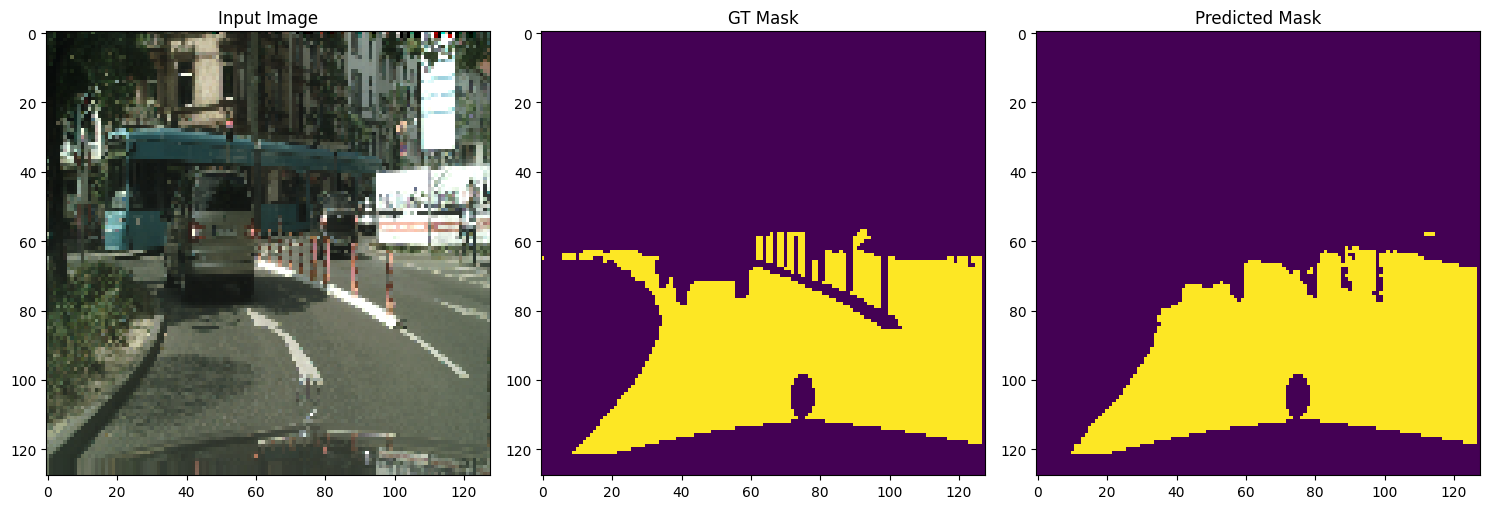

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step
 - mean_iou: 0.8999845200314214
75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 663ms/step - accuracy: 0.9834 - loss: 0.0446 - val_accuracy: 0.9750 - val_loss: 0.0715
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


<Figure size 640x480 with 0 Axes>

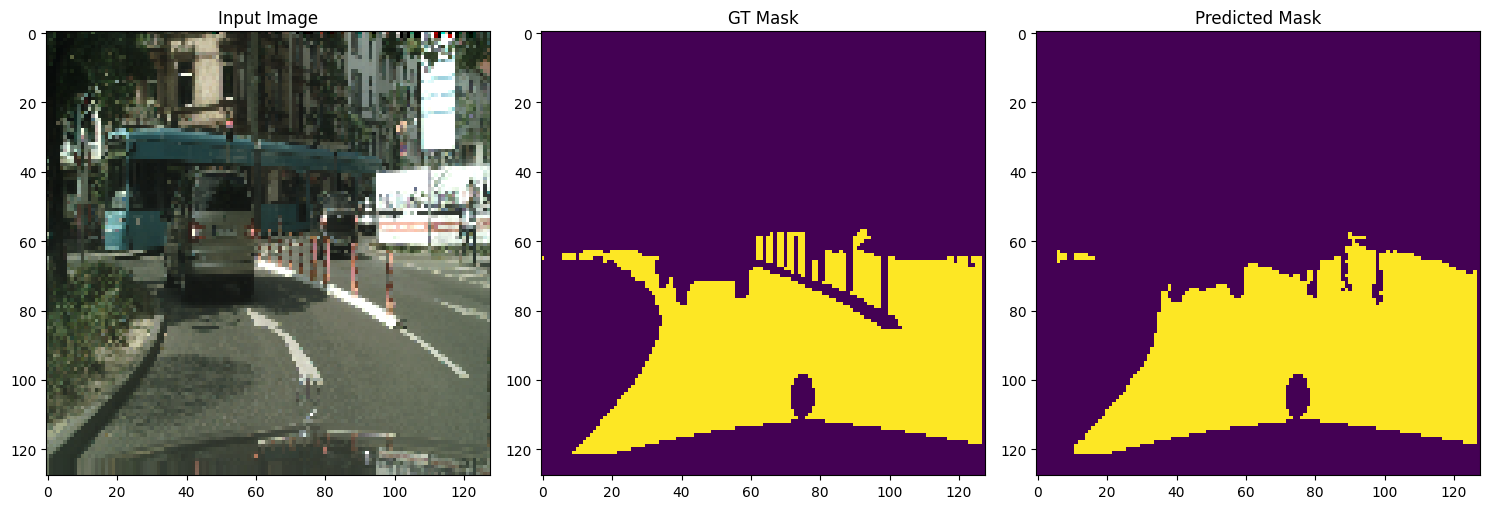

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step
 - mean_iou: 0.8944637504882313
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 584ms/step - accuracy: 0.9873 - loss: 0.0335 - val_accuracy: 0.9748 - val_loss: 0.0958
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


<Figure size 640x480 with 0 Axes>

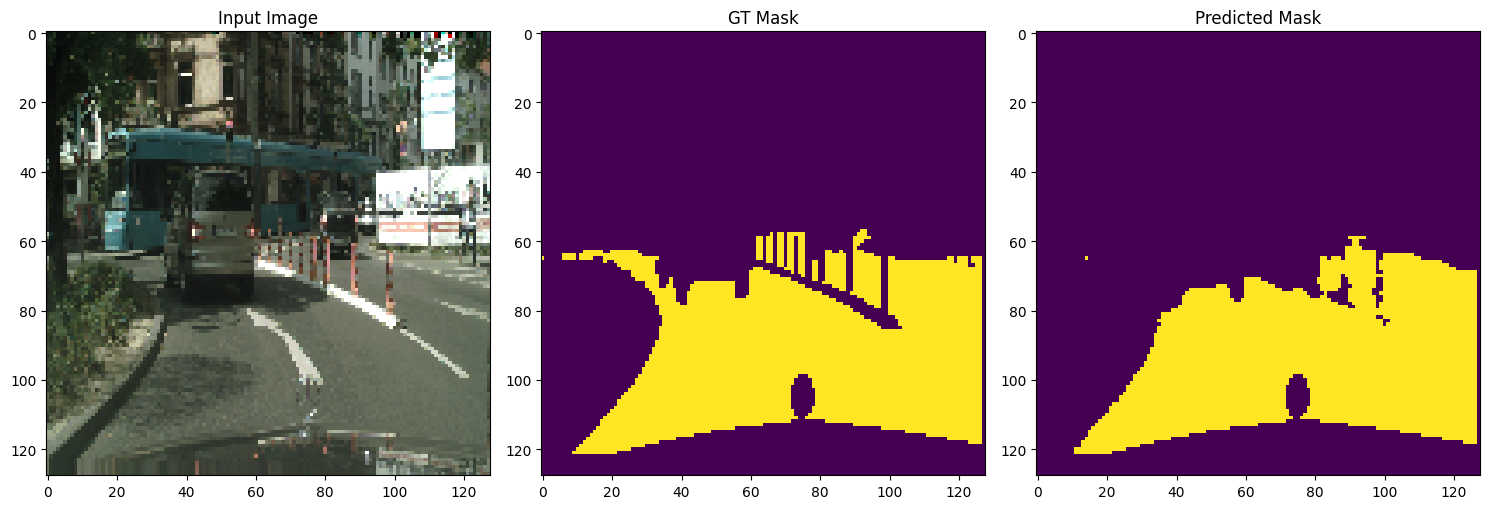

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step
 - mean_iou: 0.9021877744624018
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 599ms/step - accuracy: 0.9882 - loss: 0.0308 - val_accuracy: 0.9768 - val_loss: 0.0795
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


<Figure size 640x480 with 0 Axes>

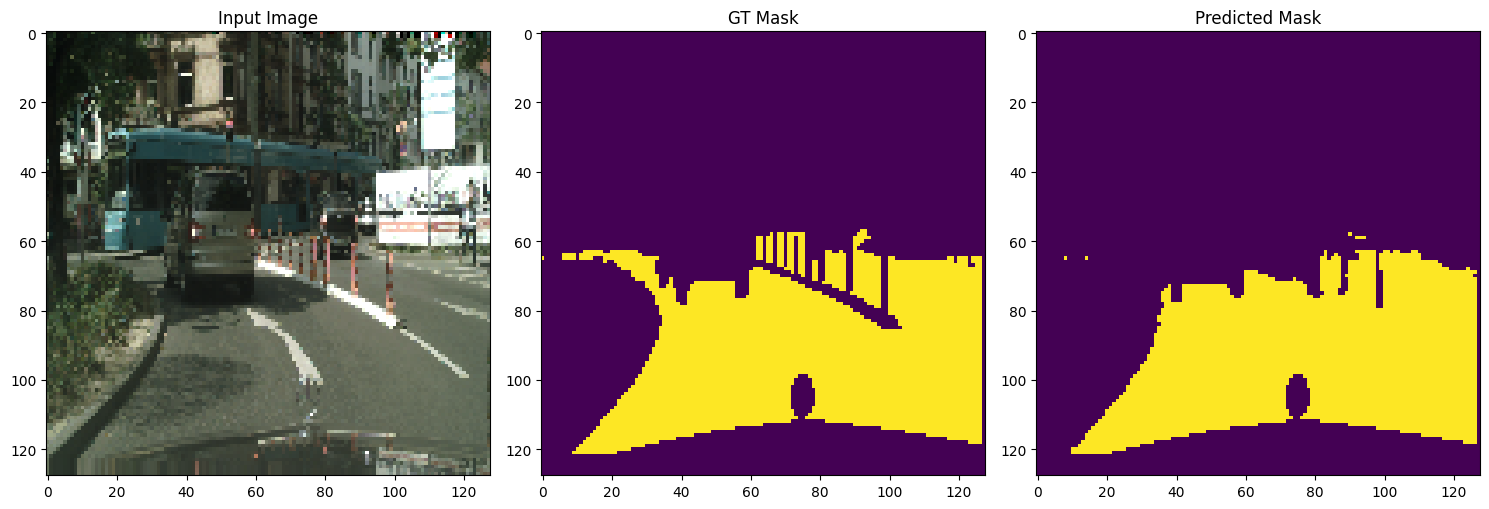

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step
 - mean_iou: 0.9038706066932539
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 601ms/step - accuracy: 0.9896 - loss: 0.0271 - val_accuracy: 0.9748 - val_loss: 0.1003
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


<Figure size 640x480 with 0 Axes>

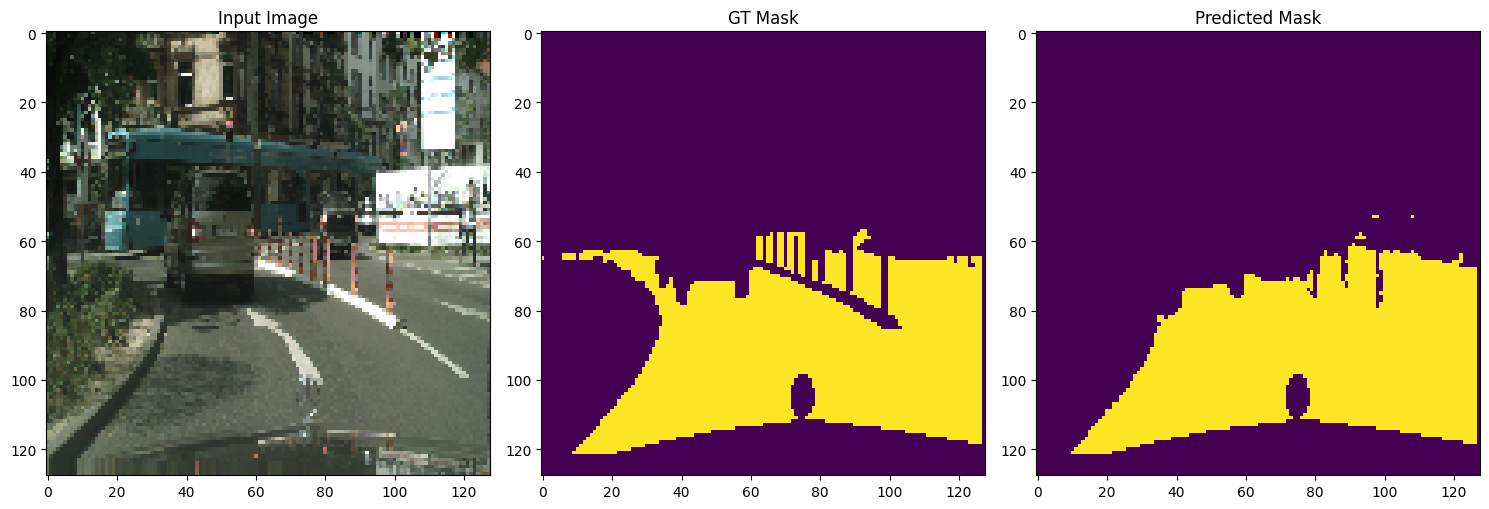

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step
 - mean_iou: 0.8988671399520215
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 570ms/step - accuracy: 0.9894 - loss: 0.0284 - val_accuracy: 0.9755 - val_loss: 0.0864
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


<Figure size 640x480 with 0 Axes>

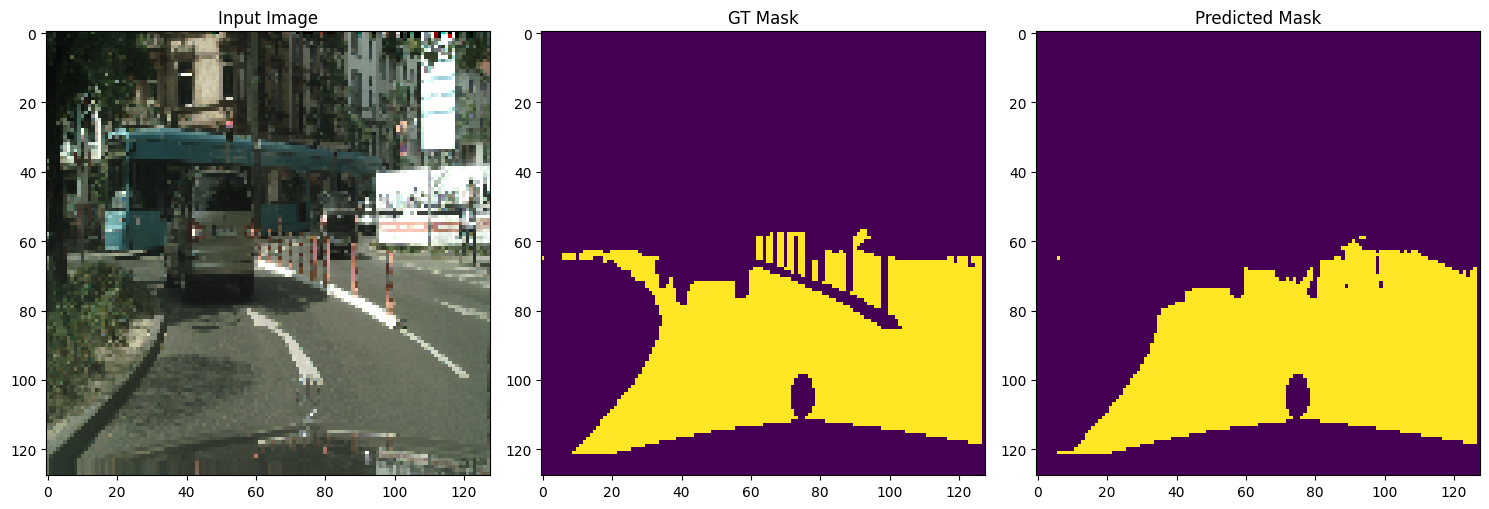

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step
 - mean_iou: 0.8966258373503045
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 568ms/step - accuracy: 0.9886 - loss: 0.0303 - val_accuracy: 0.9731 - val_loss: 0.0837
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


<Figure size 640x480 with 0 Axes>

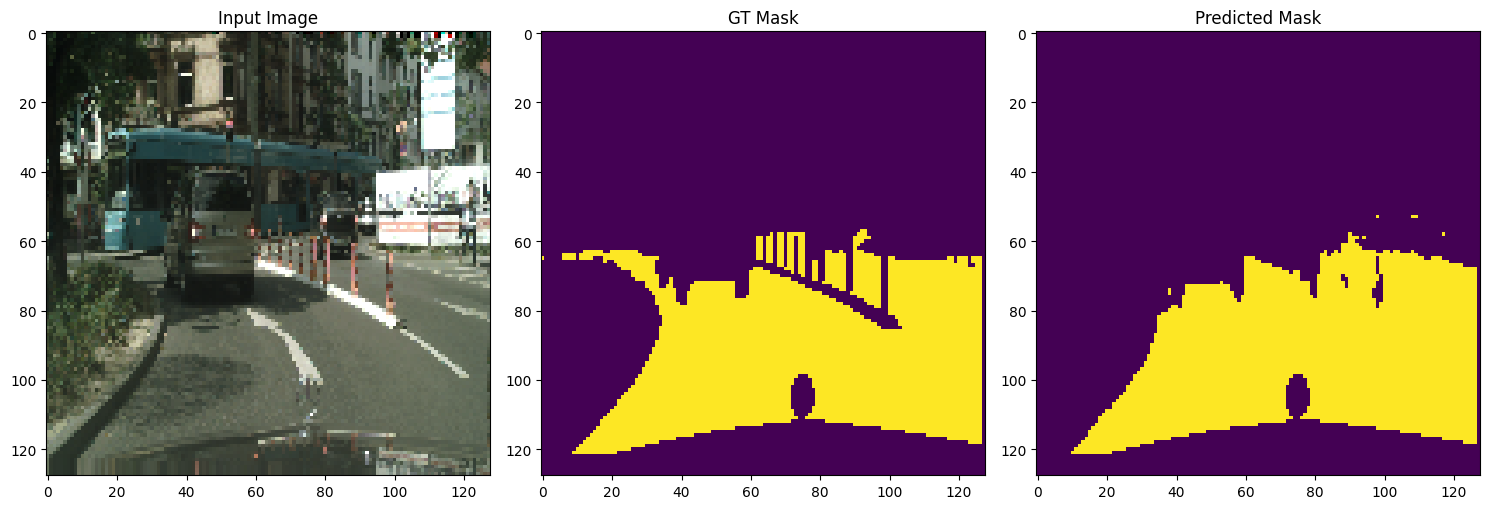

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step
 - mean_iou: 0.8982589367321195
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 600ms/step - accuracy: 0.9859 - loss: 0.0375 - val_accuracy: 0.9733 - val_loss: 0.0836
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


<Figure size 640x480 with 0 Axes>

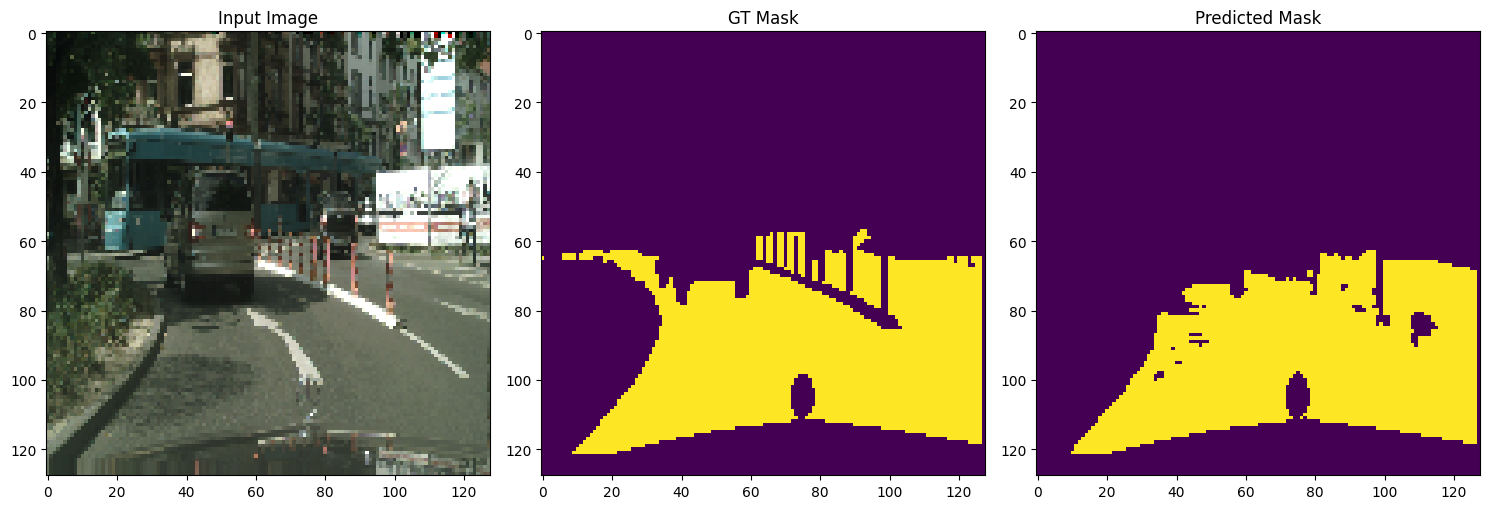

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step
 - mean_iou: 0.8721299658976597
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 574ms/step - accuracy: 0.9823 - loss: 0.0485 - val_accuracy: 0.9691 - val_loss: 0.0897
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<Figure size 640x480 with 0 Axes>

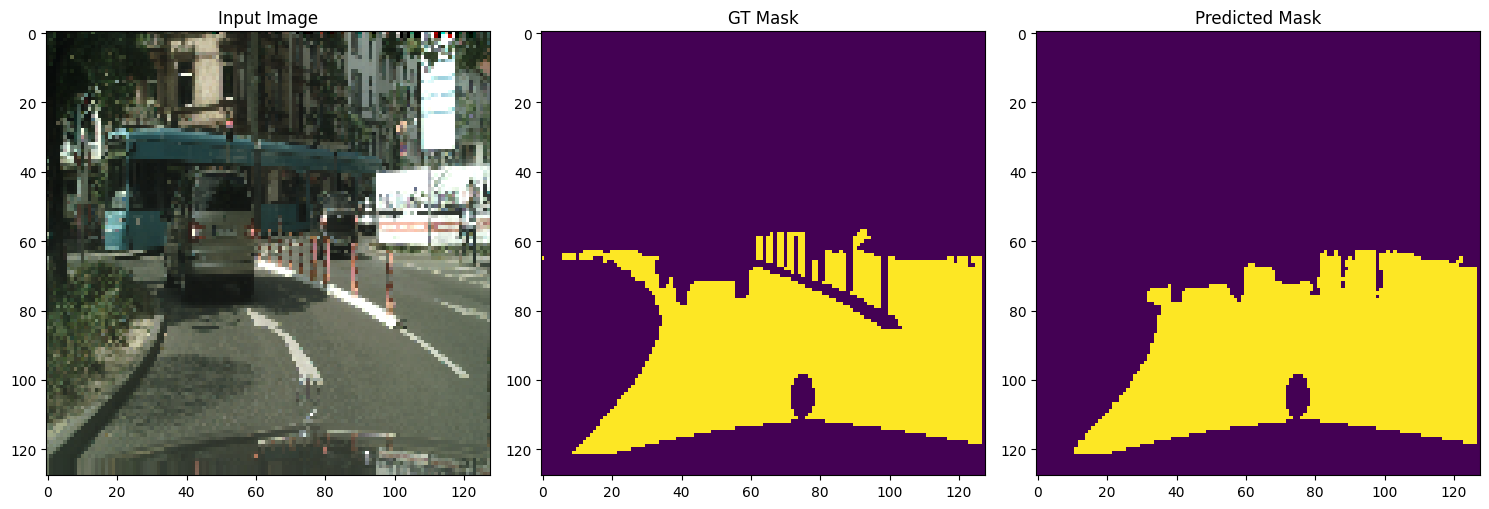

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step
 - mean_iou: 0.8976204715144834
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 574ms/step - accuracy: 0.9860 - loss: 0.0374 - val_accuracy: 0.9758 - val_loss: 0.0845
Epoch 10/20


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [27]:
# Train

configs = {"epochs": 20, "batch_size": 32, "input_shape": input_shape, "num_of_filters": 64, "num_of_classes": 2, "checkpoint": "20250329-194144"}
save_dir = os.path.join("results", datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(save_dir, exist_ok=True)

if configs["checkpoint"] == "":
  model = UNet(configs["input_shape"], configs["num_of_filters"], configs["num_of_classes"]).build()
else:
  checkpoint_path = os.path.join("results/{}".format(configs["checkpoint"]), "model_checkpoint.keras")
  model = tf.keras.models.load_model(checkpoint_path)

#unet.train(x=X_train[:100], y=Y_train[:100], x_test=X_val[:10], y_test=Y_val[:10], configs=configs, save_dir=save_dir)
unet.train(x=X_train, y=Y_train, x_test=X_val, y_test=Y_val, configs=configs, save_dir=save_dir)


TODO:
- (256,256) vs (128, 128)
- binary class vs multi-class
- categorical_crossentropy vs SparseCategoricalCrossentropy

In [46]:
zip_filename = "unet_train_results"
shutil.make_archive(zip_filename, 'zip', '/content')

'/content/unet_train_results.zip'

In [52]:
from google.colab import drive
drive.flush_and_unmount()  # Unmount first
drive.mount('/content/drive')  # Remount

shutil.move(zip_filename + ".zip", "/content/drive/MyDrive")

Mounted at /content/drive


'/content/drive/MyDrive/unet_train_results.zip'